## QDenseBatchnorm Test Notebook
***
QDenseBatchnorm should fold quantized Dense parameters into the the Batchnorm layer to reduce the LUT (look up table) utilization at HLS and Vivado FPGA Implementation time

In [12]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import common as com
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Activation
from tensorflow.keras.regularizers import l1
from qkeras.qlayers import QDense, QActivation
from qkeras import QDenseBatchnorm
from qkeras.quantizers import quantized_bits, quantized_relu
import hls4ml
from plot_roc import plot_roc
from tqdm.notebook import tqdm

os.environ['PATH'] = '/tools/Xilinx/Vivado/2019.1/bin:' + os.environ['PATH']

In [2]:
def print_dict(d, indent=0):
    align = 20
    for key, value in d.items():
        print('  ' * indent + str(key), end='')
        if isinstance(value, dict):
            print()
            print_dict(value, indent+1)
        else:
            print(':' + ' ' * (20 - len(key) - 2 * indent) + str(value))

### Load model and test data

In [3]:
import keras_model
#83.3 accuracy
#model = keras_model.load_model('model/model_config/ad06_fold_bn_16_6/model_ToyCar.h5')

#83.1 accuracy
model = keras_model.load_model('model/model_config/fold_bn_64input_depth2_12_6/model_ToyCar.h5')
output_dir = 'hls/fold_bn_64input_depth2_12_6_relu_merge'
hls4ml_config = 'model/model_config/fold_bn_64input_depth2_12_6/hls4ml_config.yml'
model.summary()
# if train_data available, load processed data in local directory without reprocessing wav files --saves time--
X_npy_dir = 'test_data/anomaly_detection/evaluation/downsampled_128_5_to_32_2_skip_method.npy'
y_npy_dir = 'test_data/anomaly_detection/evaluation/downsampled_128_5_to_32_2_ground_truths_skip_method.npy'
X = np.load(X_npy_dir, allow_pickle=1)


2022-01-31 22:54:04.741270: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-31 22:54:04.751583: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-31 22:54:04.752398: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-31 22:54:04.754257: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64)]              0         
                                                                 
 q_dense_batchnorm (QDenseBa  (None, 64)               4417      
 tchnorm)                                                        
                                                                 
 q_activation (QActivation)  (None, 64)                0         
                                                                 
 q_dense_batchnorm_1 (QDense  (None, 64)               4417      
 Batchnorm)                                                      
                                                                 
 q_activation_1 (QActivation  (None, 64)               0         
 )                                                               
                                                             

### Plot keras_model performance

### HLS4ML Translation of reference model

In [8]:
hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'
#hls_config = com.yaml_load(hls4ml_config)
#hls_config['Model'] = {}
hls_config = hls4ml.utils.config_from_keras_model(model, granularity='name')
hls_config['Model']['ReuseFactor'] = 16384
hls_config['Model']['Strategy'] = 'Resource'
hls_config['Model']['Precision'] = 'ap_fixed<32,16>'
hls_config['LayerName']['input_1']['Precision'] = 'ap_fixed<8,8>'
for layer in hls_config['LayerName'].keys():
    hls_config['LayerName'][layer]['Trace'] = True
    hls_config['LayerName'][layer]['ReuseFactor'] = 16384 #huge number, hls4ml will clip to #inputs*layer_width
    #hls_config['LayerName'][layer]['accum_t'] = 'ap_fixed<12,5>'

# relu _merge
hls_config['SkipOptimizers'] = ['relu_merge']
#hls_config['Model']['MergedRelu'] = 1
    
cfg = hls4ml.converters.create_config(
            backend='Vivado',
            part='xc7z020clg400-1',
            clock_period=10,
            io_type='io_stream')

cfg['HLSConfig'] = hls_config
cfg['InputData'] = 'test_data/anomaly_detection/test_bench/downsampled_128_5_to_32_2_skip_method.npy'
cfg['OutputPredictions'] = 'test_data/anomaly_detection/test_bench/downsampled_128_5_to_32_2_ground_truths_skip_method.npy'
cfg['KerasModel'] = model
cfg['OutputDir'] = output_dir

print("-----------------------------------")
print_dict(cfg)
print("-----------------------------------")

hls_model = hls4ml.converters.keras_to_hls(cfg)

hls_model.compile()

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: q_dense_batchnorm, layer type: QDenseBatchnorm
Layer name: q_activation, layer type: QActivation
Layer name: q_dense_batchnorm_1, layer type: QDenseBatchnorm
Layer name: q_activation_1, layer type: QActivation
Layer name: q_dense_batchnorm_2, layer type: QDenseBatchnorm
Layer name: q_activation_2, layer type: QActivation
Layer name: q_dense_batchnorm_3, layer type: QDenseBatchnorm
Layer name: q_activation_3, layer type: QActivation
Layer name: q_dense_batchnorm_4, layer type: QDenseBatchnorm
Layer name: q_activation_4, layer type: QActivation
Layer name: q_dense, layer type: QDense
-----------------------------------
OutputDir:           hls/fold_bn_64input_depth2_12_6_relu_merge
ProjectName:         myproject
Backend:             Vivado
XilinxPart:          xc7z020clg400-1
Board:               None
ClockPeriod:         10
IOType:              io_stream
HLSConfig
  Model
    Precision:       ap_fixed<32,16>

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 64]], output shape: [None, 64]
QDenseBatchnorm
Layer name: q_dense_batchnorm, layer type: QDenseBatchnorm, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: q_activation, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
QDenseBatchnorm
Layer name: q_dense_batchnorm_1, layer type: QDenseBatchnorm, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: q_activation_1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
QDenseBatchnorm
Layer name: q_dense_batchnorm_2, layer type: QDenseBatchnorm, input shapes: [[None, 64]], output shape: [None, 8]
Layer name: q_activation_2, layer type: Activation, input shapes: [[None, 8]], output shape: [None, 8]
QDenseBatchnorm
Layer name: q_dense_batchnorm_3, layer type: QDenseBatchnorm, input shapes: [[None, 8]], output shape: [None, 64]
Layer name: q_activation_3, layer type: Ac

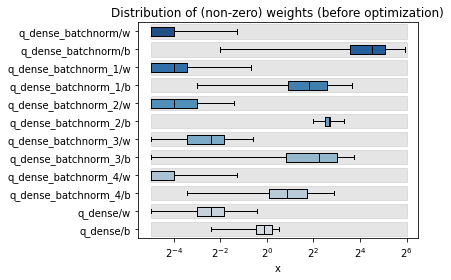

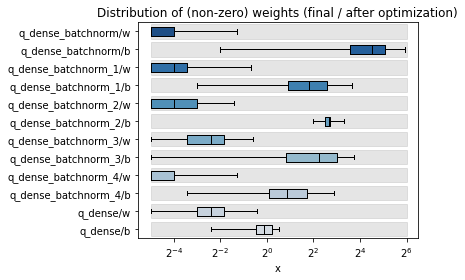

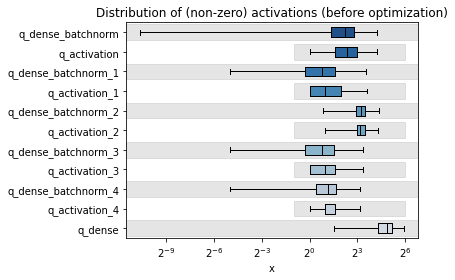

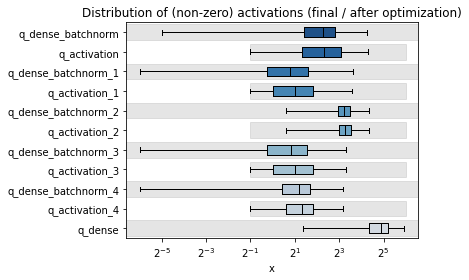

In [9]:
%matplotlib inline
_= hls4ml.model.profiling.numerical(model=model, hls_model=hls_model,X=X[0][0])
# Run tracing on a portion of the test set for the hls model (fixed-point precision) 
hls4ml_pred, hls4ml_trace = hls_model.trace(np.ascontiguousarray(X[0][0][0]))

# Run tracing on a portion of the test set for the Keras model (floating-point precision)
keras_trace = hls4ml.model.profiling.get_ymodel_keras(model, X[0][0])


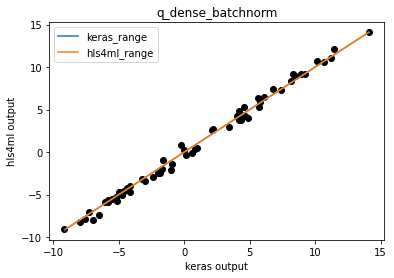

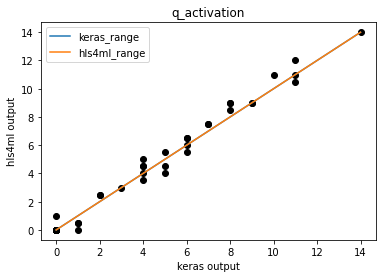

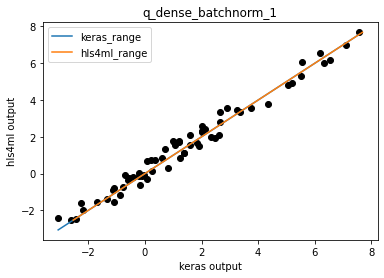

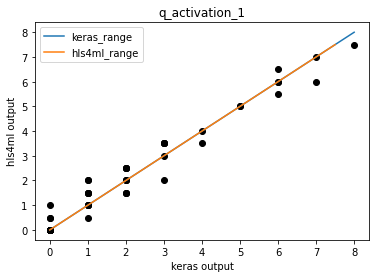

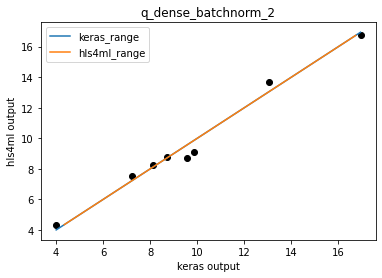

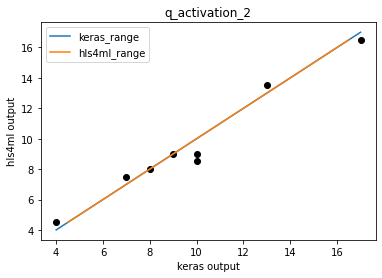

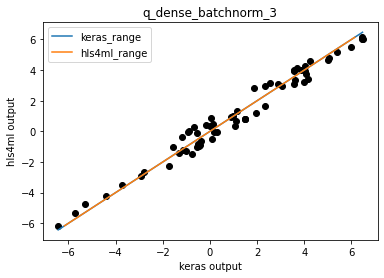

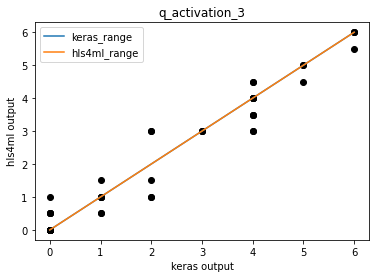

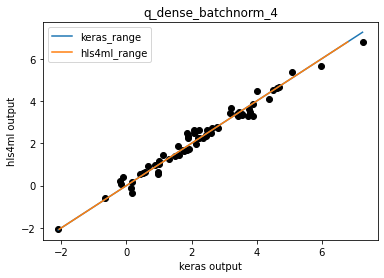

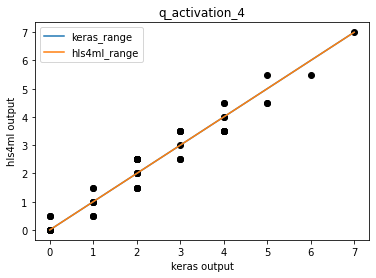

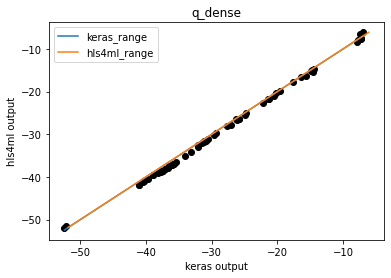

In [10]:
%matplotlib inline
for key in hls4ml_trace:
    plt.figure()
    plt.scatter(keras_trace[key][0], hls4ml_trace[key][0], color='black')
    plt.plot(np.linspace(np.min(keras_trace[key][0]),np.max(keras_trace[key][0]), 10), 
             np.linspace(np.min(keras_trace[key][0]),np.max(keras_trace[key][0]), 10), label='keras_range')
    plt.plot(np.linspace(np.min(hls4ml_trace[key][0]),np.max(hls4ml_trace[key][0]), 10), 
             np.linspace(np.min(hls4ml_trace[key][0]),np.max(hls4ml_trace[key][0]), 10), label='hls4ml_range')
    plt.title(key)
    plt.xlabel('keras output')
    plt.ylabel('hls4ml output')
    plt.legend()
    plt.show()

using one quarter of provided dataset for roc plot


  0%|          | 0/614 [00:00<?, ?it/s]

KeyboardInterrupt: 

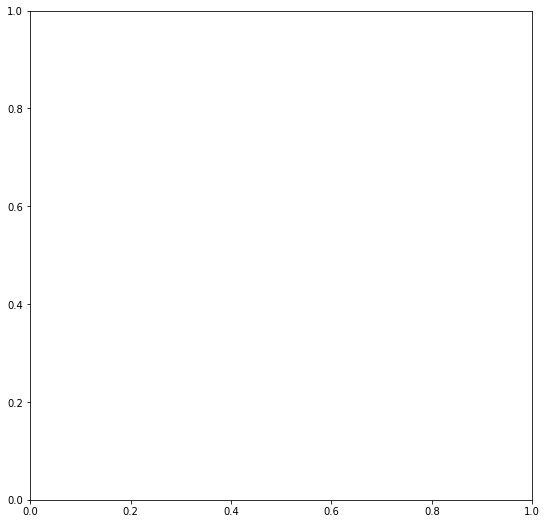

In [11]:
%matplotlib inline
plot_roc(model, hls_model, X_npy_dir, y_npy_dir,)

### Synthesize Design